In [8]:
# Importing Datetime Libraries
from datetime import datetime, timedelta
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
# MetPy Libraries
import metpy
import metpy.calc as mpcalc
from metpy.units import masked_array, units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo
from metpy.constants import g

In [9]:
# MetPy Function
def plot_maxmin_points(AX,Symbol_Size,Text_Size,lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    data = data/100.
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)
    #print mxy,mxx

    for i in range(len(mxy)):
        #ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
        #        clip_on=True, horizontalalignment='center', verticalalignment='center',
        #        transform=transform)
        #ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
        #        '\n' + str(np.int(data[mxy[i], mxx[i]])),
        #        color=color, size=12, clip_on=True, fontweight='bold',
        #        horizontalalignment='center', verticalalignment='top', transform=transform)
        
        
        AX.text(lon[mxx[i]], lat[mxy[i]],
                '\n' + str(np.int(data[mxy[i], mxx[i]])),
                color=color, size=Text_Size, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        AX.text(lon[mxx[i]], lat[mxy[i]], symbol, color=color, size=Symbol_Size,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)

In [10]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
model = new_cat.catalog_refs[4]
gfs_cat = model.follow()
ds = gfs_cat.datasets[0]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Full Collection (Reference / Forecast Time) Dataset
Path: grib/NCEP/GFS/Global_0p25deg/TwoD


In [11]:
now = datetime.utcnow()

ds = gfs_cat.datasets[1]
subset = ds.subset()
query_data = subset.query()
#query_data.lonlat_box(west=-130, east=-50, south=10, north=60)

# Allow for NetCDF files
query_data.accept('netcdf4')
query_data.time(now)
data = query_data.variables("Pressure_reduced_to_MSL_msl",
               'Apparent_temperature_height_above_ground',
                'u-component_of_wind_height_above_ground',
               'v-component_of_wind_height_above_ground')

# Finally attempt to access the data
data = subset.get_data(query_data)
    #for i in data.variables.keys(): print "Variables:",i,"\n"
    
    # Pull out variables you want to use
mslp = data.variables['Pressure_reduced_to_MSL_msl'][:].squeeze()
#mslp = mslp/100.
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
smooth_mslp = ndimage.gaussian_filter(mslp, sigma=3, order=0) * units.Pa
smooth_mslp.ito('hPa')
lat = data.variables['lat'][:].squeeze()
lon = data.variables['lon'][:].squeeze()
lon_2d, lat_2d = np.meshgrid(lon, lat)

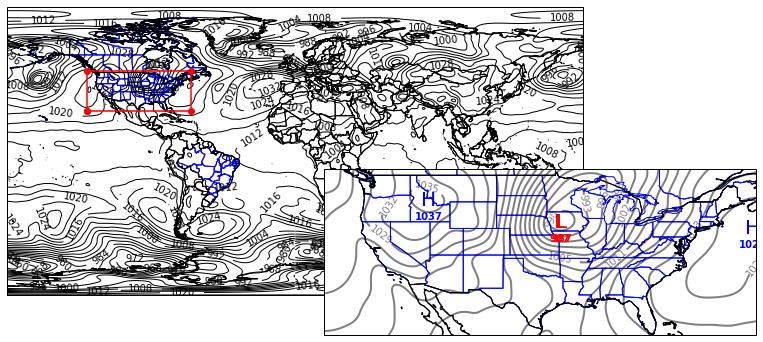

In [12]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')


# Create a large figure:
fig = plt.figure(figsize=(10, 10))

# Add an axes set and draw coastlines:
ax1 = plt.axes([0.01, 0.49, 0.8, 0.5], projection=ccrs.PlateCarree())
ax1.set_global()
ax1.coastlines()

# Add state boundaries to plot
ax1.add_feature(states_provinces, edgecolor='blue', linewidth=1)

# Add country borders to plot
ax1.add_feature(country_borders, edgecolor='black', linewidth=1)

# Add a second axes set (overlaps first) and draw coastlines:
ax2 = plt.axes([0.45, 0.35, 0.6, 0.5], projection=ccrs.PlateCarree())
#ax2.set_extent([-44, 45, -15, 45], crs=ccrs.PlateCarree())
ax2.set_extent([-130, -65, 25, 50], crs=ccrs.PlateCarree())
ax2.coastlines()
# Add state boundaries to plot
ax2.add_feature(states_provinces, edgecolor='blue', linewidth=1)

# Add country borders to plot
ax2.add_feature(country_borders, edgecolor='black', linewidth=1)
# Draw the rectangular extent of the second plot on the first:
x = [-44, 45, 45, -44, -44]
y = [-15, -15, 45, 45, -15]

# -44, 45, -15, 45
# -130, -65, 25, 50
x = [-130, -65, -65, -130, -130]
y = [25, 25, 50, 50, 25]
#ax1.fill(x, y, transform=ccrs.PlateCarree(), color='red', alpha=0.5,fill=False) #color='#0323E4'
ax1.plot(x, y, transform=ccrs.PlateCarree(), marker='o',color='red')
clev_mslp = np.arange(0, 1200, 4)

cs = ax1.contour(lon_2d, lat_2d, smooth_mslp, clev_mslp, colors='k', linewidths=1,
    linestyles='solid', transform=ccrs.PlateCarree()) # cmap='rainbow

plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True,colors='k')

clev_mslp2 = np.arange(0, 1200, 3)
cs2 = ax2.contour(lon_2d, lat_2d, smooth_mslp, clev_mslp2, colors='k', linewidths=2,
    linestyles='solid', transform=ccrs.PlateCarree(),alpha=0.5) # cmap='rainbow

plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True,colors='k')


# plot_maxmin_points(AX,lon, lat, data, extrema, nsize, symbol, color='k',Symbol_Size,Text_Size,
    #plotValue=True, transform=None)
    
#plot_maxmin_points(ax1,lon, lat, mslp, 'max', 50, symbol='H', color='b',  transform=ccrs.PlateCarree())
#plot_maxmin_points(ax1,lon, lat, mslp, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree())

plot_maxmin_points(ax2,20,10,lon, lat, mslp, 'max', 50, symbol='H', color='b',  transform=ccrs.PlateCarree())
plot_maxmin_points(ax2,20,10,lon, lat, mslp, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree())
# Now try and draw a line from the bottom left corner of the second axes set
# to the bottom left corner of the extent rectangle in the first plot:
#transFigure = fig.transFigure.inverted()
#coord1 = transFigure.transform(ax2.transAxes.transform([0, 0]))
#coord2 = transFigure.transform(ax1.transData.transform([-45, -15]))
#line = plt.Line2D((coord1[0], coord2[0]), (coord1[1], coord2[1]), transform=fig.transFigure)
#fig.lines.append(line)

plt.show()

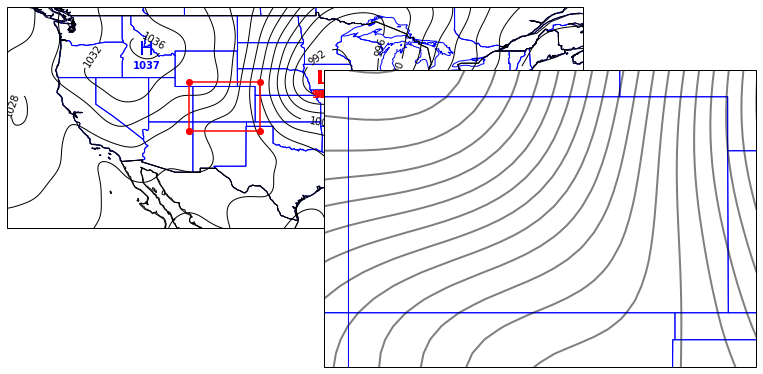

In [15]:
# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')


# Create a large figure:
fig = plt.figure(figsize=(10, 10))

# Add an axes set and draw coastlines:
ax1 = plt.axes([0.01, 0.49, 0.8, 0.5], projection=ccrs.PlateCarree())
ax1.set_extent([-130, -65, 25, 50], ccrs.PlateCarree())
#ax1.set_global()
ax1.coastlines()

# Add state boundaries to plot
ax1.add_feature(states_provinces, edgecolor='blue', linewidth=1)

# Add country borders to plot
ax1.add_feature(country_borders, edgecolor='black', linewidth=1)

# Add a second axes set (overlaps first) and draw coastlines:
ax2 = plt.axes([0.45, 0.35, 0.6, 0.5], projection=ccrs.PlateCarree())
#ax2.set_extent([-44, 45, -15, 45], crs=ccrs.PlateCarree())
#ax2.set_extent([-130, -65, 25, 50], crs=ccrs.PlateCarree())
ax2.set_extent([-109.5,-101.5,36,41.5], crs=ccrs.PlateCarree())
ax2.coastlines()
# Add state boundaries to plot
ax2.add_feature(states_provinces, edgecolor='blue', linewidth=1)

# Add country borders to plot
ax2.add_feature(country_borders, edgecolor='black', linewidth=1)
# Draw the rectangular extent of the second plot on the first:
#x = [-44, 45, 45, -44, -44]
#y = [-15, -15, 45, 45, -15]

# -44, 45, -15, 45
# -130, -65, 25, 50
# -110,-100,35,41
x = [-109.5, -101.5, -101.5, -109.5, -109.5]
y = [36, 36, 41.5, 41.5, 36]
#ax1.fill(x, y, transform=ccrs.PlateCarree(), color='red', alpha=0.5,fill=False) #color='#0323E4'
ax1.plot(x, y, transform=ccrs.PlateCarree(), marker='o',color='red')
clev_mslp = np.arange(0, 1200, 4)

cs = ax1.contour(lon_2d, lat_2d, smooth_mslp, clev_mslp, colors='k', linewidths=1,
    linestyles='solid', transform=ccrs.PlateCarree()) # cmap='rainbow

plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True,colors='k')

clev_mslp2 = np.arange(0, 1200, 1)
cs2 = ax2.contour(lon_2d, lat_2d, smooth_mslp, clev_mslp2, colors='k', linewidths=2,
    linestyles='solid', transform=ccrs.PlateCarree(),alpha=0.5) # cmap='rainbow

plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True,colors='k')


# plot_maxmin_points(AX,lon, lat, data, extrema, nsize, symbol, color='k',Symbol_Size,Text_Size,
    #plotValue=True, transform=None)
    
#plot_maxmin_points(ax1,lon, lat, mslp, 'max', 50, symbol='H', color='b',  transform=ccrs.PlateCarree())
#plot_maxmin_points(ax1,lon, lat, mslp, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree())

plot_maxmin_points(ax1,20,10,lon, lat, mslp, 'max', 50, symbol='H', color='b',  transform=ccrs.PlateCarree())
plot_maxmin_points(ax1,20,10,lon, lat, mslp, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree())
# Now try and draw a line from the bottom left corner of the second axes set
# to the bottom left corner of the extent rectangle in the first plot:
#transFigure = fig.transFigure.inverted()
#coord1 = transFigure.transform(ax2.transAxes.transform([0, 0]))
#coord2 = transFigure.transform(ax1.transData.transform([-45, -15]))
#line = plt.Line2D((coord1[0], coord2[0]), (coord1[1], coord2[1]), transform=fig.transFigure)
#fig.lines.append(line)

plt.show()